# | Practice 3-1 | Lightweight CNN

**Tensorflow Functional API**를 이용하여 이미지를 구분하는 MobileNet V2를 구현한다. <br>
그 중에서도 가장 핵심이라고 할 수 있는 **Linear bottleneck**과 **Inverted residuals**를 중점적으로 다룰 것이다.

---

## (Optional) Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""
Change directory to where this file is located
"""
#%cd 'COPY&PASTE FILE DIRECTORY HERE'

## Import Modules

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Activation, Flatten, Conv2D, \
    DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

`BatchNormalization(axis, momentum, epsilon)` : <br> 
https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다. 
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

## GPU Setting

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

In [ ]:
gpu_growth = False

if gpu_growth:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

---

## 0. Dataset : Cifar-10

### Load Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Data Visualization

In [ ]:
i = np.random.randint(len(x_train))
names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
plt.imshow(x_train[i])
plt.title(names[y_train[i][0]])
plt.show()

In [ ]:
# 50,000장 중 5,000장 이용
#indices = np.random.randint(low=0, high=len(x_train), size=5000)
#x_train, y_train = x_train[indices], y_train[indices]

---

## 1. MobileNetV2

paper: [MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)

### (1) Inverted Residual and Linear Bottleneck


<img src="https://user-images.githubusercontent.com/37704174/112773048-5bbfd400-906f-11eb-8e0c-62558ba0a1a2.PNG" width="500" height="500"/>

<img src="https://user-images.githubusercontent.com/37704174/112772900-5e6df980-906e-11eb-9c02-5310fa51ff43.PNG" width="300" height="300"/> 

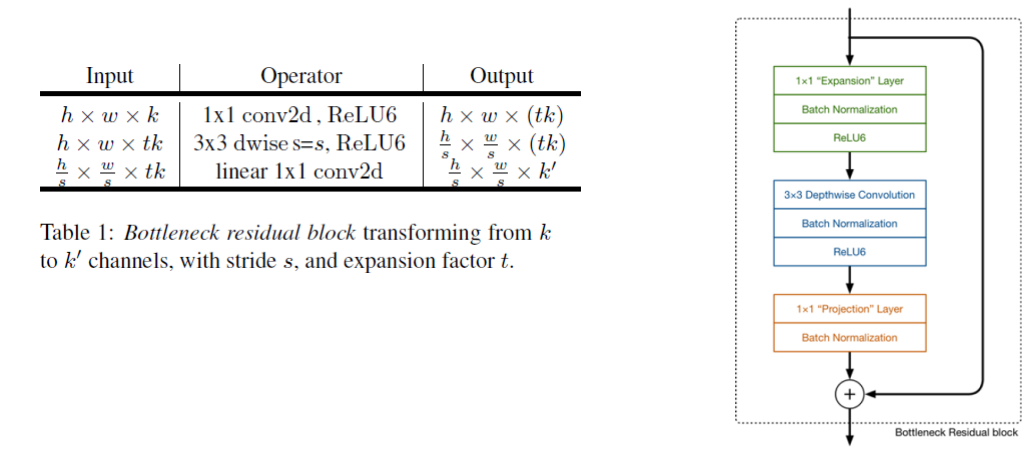

#### Expansion
  - `expansion != 1`인 <b>경우에만</b> 1x1 convolution을 이용하여 channel의 수를 `expansion`배 만큼 증가시킴
  - `strides=1`, `padding='same'`, `use_bias=False`, `kernel_regularizer=l2(4e-5)`
  - `BatchNormalization`과 ReLU6을 이용
    - BN의 `momentum=0.999`, `epsilon=0.001`
    - ReLU6은 ReLU함수에서 최대값이 6인 함수
    
#### Depthwise convolution
  - 3x3 `DepthwiseConv2D` layer를 이용
  - `strides`를 함수 입력으로 받음,  `padding=same`, `use_bias=False`, `depthwise_regularizer=l2(4e-5)`
  - `BatchNormalization`과 ReLU6을 이용
    - 위와 같음
    
    
   
#### Linear bottleneck
  - 1x1 convolution으로 channel의 수를 함수 입력으로 받는 `filters`로 줄임
  - `strides=1`, `padding='same'`, `use_bias=False`, `kernel_regularizer=l2(4e-5)`
  - `BatchNormalization`을 이용
    - 위와 같음
  - 'Linear' bottleneck이기 때문에 Activation은 이용하지 않음


#### Residual
  - input channel의 수와 `filters`가 같고, `strides`가 1인 경우에 원래 들어왔던 inputs와 Linear bottleneck의 output을 `Add` 해준다



In [ ]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    
    ########################## 실습 ##########################
    # Expansion
    if expansion != 1:
        
    # Depthwise convolution

    # Linear bottleneck
    
    # Residual connection
    if in_chnls == filters and strides == 1:
        
    #########################################################
        
    return x #return output of layer

### (2) Mobilenet V2 Network
위에서 만든 `_inverted_res_block`을 이용하여 MobilenetV2를 구성해 보도록 하자. Network의 구조는 아래 표에 요약되어 있다. <br>
<img src="https://user-images.githubusercontent.com/37704174/112775798-e527d400-9078-11eb-93b1-33cdf2f3e6f7.PNG" width="500" height="500"/>  

- `_inverted_res_block`에서 개수가 1보다 큰 것들은 첫번재 block만 `strides`가 2이고, 나머지는 1임
- Conv2D layer 다음에는 BN과 ReLU6을 이용 (`_inverted_res_block`과 hyperparameter는 같게 설정)
- Dense layer는 `activation='softmax'` 이용

In [ ]:
def MobileNetV2(input_shape, classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    ########################## 실습 ########################## 
    # inverted residual blocks

    #########################################################
    
    x = Conv2D(kernel_size=1, filters=1280, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    # global average pooling
    x = GlobalAveragePooling2D()(x)
    
    # FC layer
    outputs = Dense(classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
model = MobileNetV2(input_shape=(32,32,3), classes=10)
model.summary()

---

## 2. Training

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/50


2022-08-09 20:50:27.221539: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-09 20:50:28.102856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-08-09 20:50:29.374410: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-09 20:50:30.381728: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-09 20:50:30.614289: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 74s 43ms/step - loss: 2.0930 - accuracy: 0.2998 - val_loss: 2.4965 - val_accuracy: 0.1000
Epoch 2/50
1563/1563 [==============================] - 65s 42ms/step - loss: 1.7583 - accuracy: 0.4232 - val_loss: 2.4996 - val_accuracy: 0.1000
Epoch 3/50
1563/1563 [==============================] - 65s 41ms/step - loss: 1.7324 - accuracy: 0.4403 - val_loss: 2.2548 - val_accuracy: 0.2307
Epoch 4/50
1563/1563 [==============================] - 65s 41ms/step - loss: 1.5257 - accuracy: 0.5077 - val_loss: 2.2087 - val_accuracy: 0.4218
Epoch 5/50
1563/1563 [==============================] - 65s 42ms/step - loss: 1.4189 - accuracy: 0.5479 - val_loss: 2.2677 - val_accuracy: 0.4613
Epoch 6/50
1563/1563 [==============================] - 65s 41ms/step - loss: 1.2676 - accuracy: 0.5936 - val_loss: 1.6166 - val_accuracy: 0.5683
Epoch 7/50
1563/1563 [==============================] - 65s 42ms/step - loss: 1.2047 - accuracy: 0.6169 - val_loss: 1.6317 - val_accura